In [87]:
def function1(input1):
    """
    This function does nothing.
    """
    return input1 + " from Function 1 "
def function2(input2):
    """
    This function does nothing.
    """
    return  input2+ " from Function 2"

In [88]:
%pip install langgraph

Note: you may need to restart the kernel to use updated packages.


In [89]:
from langgraph.graph import Graph

In [90]:
workflow1=Graph()

In [91]:
workflow1.add_node(
    "function1",
    function1
)

In [92]:
workflow1.add_node(
    "function2",
    function2
)

In [93]:
workflow1.add_edge(
    "function1",
    "function2"
)

In [94]:
workflow1.set_entry_point("function1")

In [95]:
workflow1.set_finish_point("function2")

In [96]:
app1=workflow1.compile()

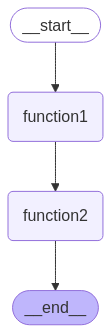

In [97]:
app1

In [98]:
# app1.invoke("Hi This is Dev")

input="Hi This is Dev"

In [99]:
for output in app1.stream(input):
    for key,value in output.items():
        print(f"here is the output: {key}")
        print("_________")
        print(value)
        print("\n")

here is the output: function1
_________
Hi This is Dev from Function 1 


here is the output: function2
_________
Hi This is Dev from Function 1  from Function 2




## Workflow with LLM

In [100]:
from langchain_google_genai import GoogleGenerativeAIEmbeddings
embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001")
from langchain.llms import Ollama
llm = Ollama(model="llama3.2:1b")


In [101]:
llm.invoke("Hi This is Dev").format()

'Hello Dev, what can I help you with today? Are you working on a project that requires some assistance or do you have any questions about a specific topic?'

In [102]:
def fun1(input1):
    """
    This function initializes the llm.
    """
    llm=Ollama(model="llama3.2:1b")
    response=llm.invoke(input1).format()
    return response

In [103]:
def func2(input2):
    """
    This function convert string to upper case.
    """
    upper_case=input2.upper()
    return upper_case

In [104]:
from langgraph.graph import Graph
workflow2=Graph()

In [105]:
workflow2.add_node("llm",fun1)

In [106]:
workflow2.add_node("upper_case",func2)

In [107]:
workflow2.add_edge("llm","upper_case")

In [108]:
workflow2.set_entry_point("llm")
workflow2.set_finish_point("upper_case")


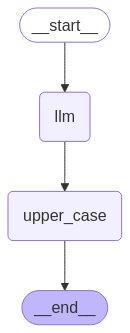

In [109]:
app2=workflow2.compile()
app2

In [110]:
app2.invoke("What is the name of the first president of the USA?")
input2="What is the name of the first president of the USA?"

### Stream Output means line by line output

In [111]:
for output in app2.stream(input):
    for key,value in output.items():
        print(f"here is the output: {key}")
        print("_________")
        print(value)
        print("\n")

here is the output: llm
_________
Hello Dev. What can I help you with today? Are you looking for information on a specific topic or project, or just need some guidance on how to get started?


here is the output: upper_case
_________
HELLO DEV. WHAT CAN I HELP YOU WITH TODAY? ARE YOU LOOKING FOR INFORMATION ON A SPECIFIC TOPIC OR PROJECT, OR JUST NEED SOME GUIDANCE ON HOW TO GET STARTED?




### Token Counter Create

In [112]:
def func3(input):
    token=input.split()
    token_number=len(token)
    token_number=f"Total Token number is {token_number}"
    return token_number

In [113]:
workflow3=Graph()
workflow3.add_node("llm",fun1)
workflow3.add_node("token_counter",func3)
workflow3.add_edge("llm","token_counter")
workflow3.set_entry_point("llm")
workflow3.set_finish_point("token_counter")


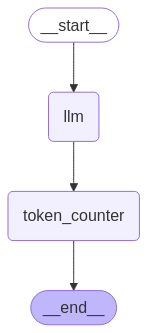

In [114]:
app3=workflow3.compile()
app3

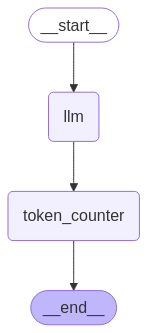

In [115]:
from IPython.display import display,Image

try:
    display(Image(app3.get_graph().draw_mermaid_png()))
except Exception as e:
    print("Error displaying graph:", e)


In [116]:
app3.invoke("What is the name of the first president of the USA?")

'Total Token number is 22'

## RAG With Graph

In [134]:
llm.invoke("What is the name of the first president of the USA?").format()

'The first president of the United States was George Washington. He served two terms in office from 1789 to 1797.'

In [ ]:
from langchain_core.output_parsers import StrOutputParser
# from langchain_core.output_parsers.retry import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_community.document_loaders import TextLoader,DirectoryLoader
from langchain_community.vectorstores import Chroma
from langchain.text_splitter import RecursiveCharacterTextSplitter

ImportError: cannot import name 'RetryOutputParser' from 'langchain_core.output_parsers' (/home/dev/Desktop/Learning/AI/graph_yt/env/lib/python3.10/site-packages/langchain_core/output_parsers/__init__.py)

In [136]:
loader=DirectoryLoader("../data",glob="**/*.txt",loader_cls=TextLoader)
docs=loader.load()
text_splitter=RecursiveCharacterTextSplitter(chunk_size=100,chunk_overlap=50)


new_docs=text_splitter.split_documents(documents=docs)
docs_strings=[doc.page_content for doc in new_docs]

db=Chroma.from_documents(new_docs,embeddings)
retriever=db.as_retriever(search_kwargs={"k":3})

query="What is Meta llama3?"
docs=retriever.get_relevant_documents(query)
print(docs[0].metadata)
print(docs[0].page_content)

for doc in docs:
    print(doc)
    


{'source': '../data/llama3.txt'}
Alongside the release of Llama 3, Meta added virtual assistant features to Facebook and WhatsApp in
page_content='Alongside the release of Llama 3, Meta added virtual assistant features to Facebook and WhatsApp in' metadata={'source': '../data/llama3.txt'}
page_content='Alongside the release of Llama 3, Meta added virtual assistant features to Facebook and WhatsApp in' metadata={'source': '../data/llama3.txt'}
page_content='Alongside the release of Llama 3, Meta added virtual assistant features to Facebook and WhatsApp in' metadata={'source': '../data/llama3.txt'}


In [137]:
def func_1(AgentState):
    message=AgentState["messages"]

    question=message[-1]

    complete_prompt="Your Task is to provide only the breif answer to the question. Do not provide any explanation. Just provide the answer. The question is: "+question

    response=llm.invoke(complete_prompt).format()

    AgentState['messages'].append(response)
    # print("from func_1")
    # print("Messages",message)
    # print("Que",question)
    # print("Agent State",AgentState)
    return AgentState

In [138]:
def func_2(AgentState):
    message=AgentState["messages"]

    question=message[0]

    template="""
    Answer the question based only on the following context:
    {context}
    Question: {question}
    """

    prompt=ChatPromptTemplate.from_template(template)
    retriever1_chain=(
        {"context":retriever , "question":RunnablePassthrough()}
        |prompt
        |llm
        |StrOutputParser()
        )

    result=retriever1_chain.invoke(question)
    
    return result

In [139]:
workflow4=Graph()
workflow4.add_node("LLM",func_1)
workflow4.add_node("RAGtool",func_2)
workflow4.add_edge("LLM","RAGtool")
workflow4.set_entry_point("LLM")
workflow4.set_finish_point("RAGtool")
app4=workflow4.compile()

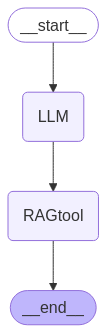

In [140]:
app4

In [142]:
input={"messages":["What is Meta llama3?"]}
for output in app4.stream(input):
    for key,value in output.items():
        print(f"here is the output: {key}")
        print("_________")
        print(value)
        print("\n")

here is the output: LLM
_________
{'messages': ['What is Meta llama3?', 'Meta Llama3 is an artificial intelligence model developed by Meta, used for a range of tasks including language translation, question answering, and text summarization.']}


here is the output: RAGtool
_________
Meta llama3.




### State based RAGtool + LLM

In [612]:
loader2=DirectoryLoader("../data2",glob="**/*.txt",loader_cls=TextLoader)
docs2=loader2.load()
text_splitter=RecursiveCharacterTextSplitter(chunk_size=100,chunk_overlap=50)
new_docs2=text_splitter.split_documents(documents=docs2)
docs_strings2=[doc.page_content for doc in new_docs2]


In [613]:
db2=Chroma.from_documents(new_docs2,embeddings)
retriever2=db2.as_retriever(search_kwargs={"k":3})

In [614]:
query ="Tell me about India's Industrial Growth?"
docs2=retriever2.get_relevant_documents(query)
print(docs2[0].metadata)
print(docs2[0].page_content)
for doc in docs2:
    print(doc)

{'source': '../data2/indian_economy.txt'}
India’s industrial growth has outpaced expectations, raising hopes that the economy will avoid a
page_content='India’s industrial growth has outpaced expectations, raising hopes that the economy will avoid a' metadata={'source': '../data2/indian_economy.txt'}
page_content='India’s industrial growth has outpaced expectations, raising hopes that the economy will avoid a' metadata={'source': '../data2/indian_economy.txt'}
page_content='India’s industrial growth has outpaced expectations, raising hopes that the economy will avoid a' metadata={'source': '../data2/indian_economy.txt'}


In [615]:
from typing import TypedDict,Annotated,Sequence
import operator
from langchain_core.messages import BaseMessage
from langchain.prompts import PromptTemplate


In [616]:
class AgentState(TypedDict):
    # The 'messages' field should be a sequence of strings, and we annotate it with 'operator.add'
    # This implies we might want to "add" new messages to the sequence later
    messages: Annotated[Sequence[BaseMessage], operator.add]

In [617]:
from pydantic import BaseModel , Field
class TopicSelectionParser(BaseModel):
    Topic: str = Field(description='Selected Topic')
    Reasoning: str = Field(description='Reasoning behind topic selection')

In [618]:
from langchain.output_parsers import PydanticOutputParser
parser = PydanticOutputParser(pydantic_object=TopicSelectionParser)

In [619]:
print(parser.get_format_instructions())

The output should be formatted as a JSON instance that conforms to the JSON schema below.

As an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}
the object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.

Here is the output schema:
```
{"properties": {"Topic": {"description": "Selected Topic", "title": "Topic", "type": "string"}, "Reasoning": {"description": "Reasoning behind topic selection", "title": "Reasoning", "type": "string"}}, "required": ["Topic", "Reasoning"]}
```


In [620]:
# import httpx
# def wikipedia(query):
#     url = "https://en.wikipedia.org/w/api.php"
#     params = {
#         "action": "query",
#         "format": "json",
#         "list": "search",
#         "srsearch": query,
#         "utf8": 1,
#         "srlimit": 1,
#     }
#     response = httpx.get(url, params=params)
#     # data = response.json()
#     # if 'query' in data and 'search' in data['query']:
#     return response.json()['query']['search'][0]['snippet']
#     # else:
#         # return None


In [640]:
from langchain.prompts import PromptTemplate


def function_1(state):
    messages = state["messages"]
    question = messages[-1]
    print(f"User question: {question}")

    # Define the prompt template
    # template = """
    # Your task is to classify the given user query into one of the following categories: [India].
    # Provide your response in the following JSON format:

    # {{
    #   "Topic": "The selected category",
    #   "Reasoning": "The reasoning behind the selection"
    # }}

    # User query: {question}
    # """
    template="""
    Your task is to classify the given user query into one of the following categories: [India, Not Related]. 
    Only respond with the category name and nothing else.
    Provide your response in the following JSON format:
    {{
      "Topic": "The selected category",
      "Reasoning": "The reasoning behind the selection"
    }}

    User query: {question}
    """

    prompt = PromptTemplate(
        template=template,
        input_variables=["question"]
    )

    # Initialize the language model
    # llm = OpenAI()

    # Create the chain
    chain = prompt | llm | parser

    # Invoke the chain
    response = chain.invoke({"question": question})
    print(f"LLM response: {response}")

    return {"messages": [response.Topic]}


In [622]:
template="""
    Your task is to classify the given user query into one of the following categories: [India, Not Related]. 
    Only respond with the category name and nothing else.

    User query: "Tell me about India's Industrial Growth"
    The output should be formatted as a JSON instance that conforms to the JSON schema below.

    As an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}
    the object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.

    Here is the output schema:
    ```
    {"properties": {"Topic": {"description": "Selected Topic", "title": "Topic", "type": "string"}, "Reasoning": {"description": "Reasoning behind topic selection", "title": "Reasoning", "type": "string"}}, "required": ["Topic", "Reasoning"]}
        """

In [623]:
state={"messages": ["Tell me about India's Industrial Growth"]}

In [641]:
function_1(state)

User question: Tell me about India's Industrial Growth
LLM response: Topic='Not Related' Reasoning='The user query contains a country name (India) but asks for information on its industrial growth, which is unrelated to that topic.'


{'messages': ['Not Related']}

In [625]:
def router(state):
    print('-> Router ->')
    
    messages = state["messages"]
    last_message = messages[-1]
    print(last_message)
    if 'India' in last_message:
        return 'RAG Call'
    else:
        return 'LLM Call'

In [626]:
def function_2(state):
    print('-> Calling RAG ->')
    messages = state['messages']
    question = messages[0] ## Fetching the user question
    print(question)

    template = """Answer the question based only on the following context:
    {context}

    Question: {question}
    """
    prompt = ChatPromptTemplate.from_template(template)
    
    print(prompt)

    retrieval_chain = (
        {"context": retriever, "question": RunnablePassthrough()}
        | prompt
        | llm
        | StrOutputParser()
        )
    result = retrieval_chain.invoke(question)
    return  {"messages": [result]}

In [627]:
function_2(state)

-> Calling RAG ->
Tell me about India's Industrial Growth
input_variables=['context', 'question'] input_types={} partial_variables={} messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, template='Answer the question based only on the following context:\n    {context}\n\n    Question: {question}\n    '), additional_kwargs={})]


{'messages': ["India's industrial growth has outpaced expectations, and this trend is expected to continue."]}

In [628]:
def function_3(state):
    print('-> Calling LLM ->')

    messages = state['messages']
    question = messages[0] ## Fetching the user question

    # Normal LLM call
    complete_query = "Anwer the follow question with your knowledge of the real world. Following is the user question: " + question
    response = llm.invoke(complete_query).format()
    return {"messages": [response]}

### Workflow building 

In [629]:
# from langgraph.graph import StateGraph, END

# workflow5= StateGraph(AgentState)
# workflow5.add_node("agent",function_1)
# workflow5.add_node("RAG",function_2)
# workflow5.add_node("LLM",function_3)
# # workflow5.add_node("WIKI",wikipedia)

# workflow5.set_entry_point("agent")


# workflow5.add_conditional_edges(
#     "agent",
#     router,
#     {
#         "RAG Call":"RAG",
#         "LLM Call":"LLM",
#         # "WIKI Call":"WIKI",
#     }
# )

# workflow5.add_edge("RAG",END)
# workflow5.add_edge("LLM",END)
# # workflow5.add_edge("WIKI",END)

# app5=workflow5.compile()

In [630]:
from langgraph.graph import StateGraph,END

workflow5 = StateGraph(AgentState) ### StateGraph with AgentState


workflow5.add_node("agent", function_1)

workflow5.add_node("RAG", function_2)

workflow5.add_node("LLM", function_3)


workflow5.set_entry_point("agent")

workflow5.add_conditional_edges(
    "agent",
    
    
    router,
    {
        "RAG Call": "RAG",
        "LLM Call": "LLM",
    }
)

workflow5.add_edge("RAG",END)


workflow5.add_edge("LLM",END)


app5=workflow5.compile()

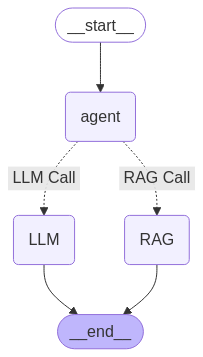

In [631]:
app5

In [632]:
inputs = {"messages": ["Tell me about India's Industrial Growth"]}

In [642]:
app5.invoke(inputs)

User question: Tell me about India's Industrial Growth
LLM response: Topic='Not Related' Reasoning="The user has not explicitly mentioned a specific industry, location or topic related to India. The question seems to be asking for a general overview of India's industrial growth."
-> Router ->
Not Related
-> Calling LLM ->


{'messages': ["Tell me about India's Industrial Growth",
  'Not Related',
  "India's industrial growth has been a remarkable story over the years. Here are some key facts:\n\n1. **Historical Context**: India's industrial growth was largely driven by its massive population, which led to an unprecedented demand for goods and services. By the 1950s, India had become one of the world's largest consumers of manufactured goods.\n2. **Post-Independence Reforms**: The introduction of economic liberalization policies in the 1990s under Prime Minister Narendra Modi's leadership has been instrumental in stimulating industrial growth. The Goods and Services Tax (GST) was rolled out in 2017, making it easier for businesses to operate and reducing tax complexity.\n3. **Manufacturing Growth**: India's manufacturing sector has experienced significant growth over the past few decades. According to the International Trade Centre, India's exports have grown from $13 billion in 2005-06 to over $430 billio